# UCEC Reccurance Notebook - Model Training

In [7]:
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, StratifiedKFold

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# TODO: Impliment these models
from xgboost import XGBClassifier
from sklearn.svm import SVC


from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, precision_score, recall_score, f1_score

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel

from sklearn.pipeline import Pipeline

from collections import Counter
import matplotlib.pyplot as plt

import joblib
import preprocessing_utils

In [3]:
# Load training data using paths from config
# X_train = joblib.load(config.X_TRAIN_PATH)
# y_train = joblib.load(config.Y_TRAIN_PATH)
X_train = joblib.load("../new_data/X_train.pkl")
y_train = joblib.load("../new_data/y_train.pkl")
X_test = joblib.load("../new_data/X_test.pkl")
y_test = joblib.load("../new_data/y_test.pkl")


# Ensure all column names are strings
non_str_cols = [col for col in X_train.columns if not isinstance(col, str)]
if non_str_cols:
    raise TypeError(f"Non-string column names found: {non_str_cols}")


In [3]:
def check_feature_alignment(X_train, X_test):
    train_cols = list(X_train.columns)
    test_cols = list(X_test.columns)

    missing = set(train_cols) - set(test_cols)
    extra = set(test_cols) - set(train_cols)

    if missing or extra:
        raise ValueError(
            f"Feature mismatch!\n"
            f"Missing in test: {missing}\n"
            f"Extra in test: {extra}\n"
        )

    if train_cols != test_cols:
        raise ValueError("Feature names match, but column order is different!")

    print("✅ Features aligned: same names and order")

check_feature_alignment(X_train, X_test)

✅ Features aligned: same names and order


In [4]:
variances = X_train.var(axis=0)
constant_features = variances[variances == 0].index.tolist()
print(constant_features)

[]


In [5]:
def run_random_forest_classifier():
    # Code for training Random Forest
    # This model is waved under random_forest_model.pkl
    print("Running random forest classifier")
    pipeline = Pipeline([
        ('variance_threshold', VarianceThreshold(threshold=1e-5)), 
        # ('scaler', StandardScaler()),
        ('select', SelectKBest(score_func=f_classif)),
        ('clf', RandomForestClassifier(random_state=config.SEED, class_weight='balanced'))
    ])

    # Define hyperparameter grid
    param_grid = {
        'clf__n_estimators': [50, 100],
        'clf__max_depth': [5, 10, 15],
        'clf__min_samples_split': [2, 4],
        'clf__min_samples_leaf': [1, 2, 4],
        'select__k': [20, 50, 100, 500],
        'clf__max_features': ['sqrt', 'log2', 0.1]  # Reduce feature space per tree
    }
    return pipeline, param_grid


def run_svc_with_LASSO():
    # Define LASSO feature selector (keep threshold and C as chosen)
    lasso_selector = SelectFromModel(
        LogisticRegression(
            penalty='l1', solver='saga', C=0.1, max_iter=5000
        ),
        threshold='mean'
    )

    # Define SVC classifier with best-found params
    svc_clf = SVC(
        probability=True,
        class_weight='balanced',
        random_state=config.SEED,
        C=0.1,
        kernel='rbf',
        gamma='scale'
    )

    # Build pipeline (no grid search)
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('feature_selection', lasso_selector),
        ('classifier', svc_clf)
    ])

    return pipeline, None  # No hyperparameter grid since params are fixed (so that the function runs faster)


def run_svc():
    # Define SVC classifier
    svc_clf = SVC(probability=True, class_weight='balanced', random_state=config.SEED)

    # Build pipeline
    pipeline = Pipeline([
        ('variance', VarianceThreshold(threshold=0.001)),   # Remove constant features
        ('scaler', StandardScaler()),
        ('select', SelectKBest(score_func=f_classif, k=1000)),
        ('classifier', svc_clf)
    ])

    # Hyperparameter grid
    param_grid = {
        'select__k': [20, 50, 100, 500],
        'classifier__C': [0.1, 1, 10],
        'classifier__kernel': ['linear', 'rbf'],
        'classifier__gamma': ['scale', 'auto']
    }

    return pipeline, param_grid

#FIXME: hasn't finished running after 87 minutes, need to remove LASSO or reduce hyperparameter grid
# Overall best params: {'classifier__learning_rate': 0.01, 'classifier__max_depth': 3, 'classifier__n_estimators': 50, 'feature_selection__estimator__C': 0.1} 
# FIXME: Took: 859 minutes
# 1 fits failed out of a total of 162. Not sure why.
# right now, is predicted all 0s. Which is werid because the mean aur-roc was 0.6413, so why is it now 0,5 even on the training data?
# ok, so now it is dramatically overfitting. 
# takes roughly 14 minutes when hyperparameters are set. 
def run_xgboost_with_LASSO(y_train):
    # Define LASSO feature selector
    lasso_selector = SelectFromModel(
        LogisticRegression(penalty='l1', solver='saga', C=0.1, max_iter=5000),
        threshold='mean'  # or use "1e-5" to keep more
    )

    # Define XGBoost classifier
    xgb_clf = XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=config.SEED,
        scale_pos_weight=(np.sum(y_train == 0) / np.sum(y_train == 1))  # ratio of negatives over positives
    )

    # Build pipeline
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('feature_selection', lasso_selector),
        ('classifier', xgb_clf)
    ])

    # Hyperparameter grid
    # param_grid = {
    #     'feature_selection__estimator__C': [0.01, 0.1, 1],
    #     'classifier__n_estimators': [50, 100],
    #     'classifier__max_depth': [3, 5, 7],
    #     'classifier__learning_rate': [0.01, 0.1, 0.2],
    # }
    param_grid = {
        'feature_selection__estimator__C': [0.1],
        'classifier__n_estimators': [50],
        'classifier__max_depth': [3],
        'classifier__learning_rate': [0.01],
    }
    return pipeline, param_grid


def run_xgboost(y_train):
    # Define XGBoost classifier
    xgb_clf = XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=config.SEED,
        scale_pos_weight=(np.sum(y_train == 0) / np.sum(y_train == 1))  # balance classes
    )

    # Build pipeline (scaler + classifier)
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', xgb_clf)
    ])

    # Define hyperparameter grid
    param_grid = {
        'classifier__n_estimators': [100, 200, 300],
        'classifier__max_depth': [3, 5, 7],
        'classifier__learning_rate': [0.01, 0.1, 0.2],
        'classifier__subsample': [0.8, 1.0],
        'classifier__colsample_bytree': [0.8, 1.0]
    }
    return pipeline, param_grid


def run_LASSO():
    print("Running Logistic Regression with LASSO")

    pipeline = Pipeline([
        ('variance_threshold', VarianceThreshold(threshold=0.001)),
        ('scaler', StandardScaler()),
        ('clf', LogisticRegression(
            penalty='l1',
            solver='saga',
            class_weight='balanced',
            random_state=config.SEED,
            max_iter=10000,
            verbose=1
        ))
    ])

    param_grid = {
        'clf__C': [0.01, 0.1, 1, 10],  # Smaller C = more sparsity
    }

    return pipeline, param_grid


In [6]:
# pipeline, _ = run_svc_with_LASSO()

# # Fit pipeline on training data
# pipeline.fit(X_train, y_train)

# best_model = pipeline


In [7]:
# CHANGE WHICH MODEL USED HERE ########################################################
pipeline, param_grid = run_LASSO()

# Set up cross-validation
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=config.SEED)

# Grid search over pipeline
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring='roc_auc',  # Or 'f1' if recurrence class is more important
    n_jobs=-1,
    verbose=3
)

# Fit pipeline on training data
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

Running Logistic Regression with LASSO
Fitting 3 folds for each of 4 candidates, totalling 12 fits
convergence after 1657 epochs took 3 seconds


Looking at the hyperparameter tuning

In [8]:
print("Overall best params:", grid_search.best_params_, "\n")

# Retrieve the results from grid search
cv_results = grid_search.cv_results_

# Extract the mean test scores for each parameter combination
mean_test_scores = cv_results['mean_test_score']

# Extract the standard deviation of test scores for each parameter combination
std_test_scores = cv_results['std_test_score']

# Extract the parameter settings for each run
params = cv_results['params']

# Print the AUC-ROC scores for each parameter combination
for mean, std, param in zip(mean_test_scores, std_test_scores, params):
    print(f"Parameters: {param}")
    print(f"Mean AUC-ROC: {mean:.4f}")
    print(f"Standard Deviation: {std:.4f}")
    print("-" * 30)


Overall best params: {'clf__C': 1} 

Parameters: {'clf__C': 0.01}
Mean AUC-ROC: 0.5000
Standard Deviation: 0.0000
------------------------------
Parameters: {'clf__C': 0.1}
Mean AUC-ROC: 0.7387
Standard Deviation: 0.0237
------------------------------
Parameters: {'clf__C': 1}
Mean AUC-ROC: 0.7408
Standard Deviation: 0.0514
------------------------------
Parameters: {'clf__C': 10}
Mean AUC-ROC: 0.7331
Standard Deviation: 0.0477
------------------------------


In [9]:
# Save the best estimator from GridSearchCV
# joblib.dump(best_model, XXXXXXXXXX) # change the path depending on the model

Analyzing the prediction of the training data

Training Data Evaluation Metrics:
True Positives (TP): 67
False Positives (FP): 2
True Negatives (TN): 327
False Negatives (FN): 0
Precision: 0.971
Recall: 1.000
AUC-ROC Score: 1.0000


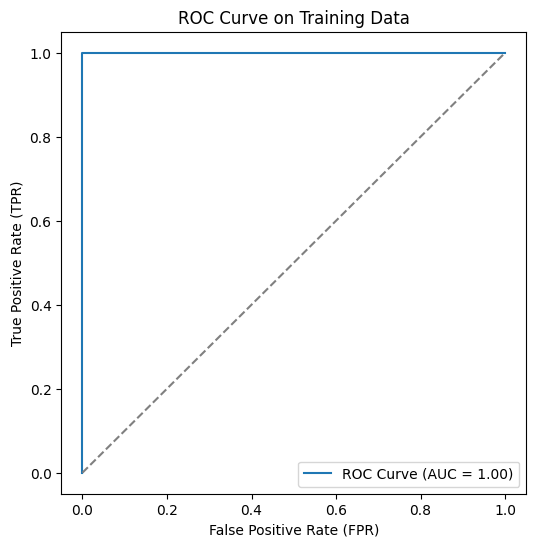

In [10]:
# Training Data Evaluation Metrics

# Predictions (discrete)
y_train_pred = best_model.predict(X_train)

print("Training Data Evaluation Metrics:")

# Confusion matrix
cm_train = confusion_matrix(y_train, y_train_pred)
tn, fp, fn, tp = cm_train.ravel()
print(f"True Positives (TP): {tp}")
print(f"False Positives (FP): {fp}")
print(f"True Negatives (TN): {tn}")
print(f"False Negatives (FN): {fn}")

# Precision & Recall
precision = precision_score(y_train, y_train_pred)
recall = recall_score(y_train, y_train_pred)
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")

# Continuous scores for AUROC
if hasattr(best_model, "predict_proba"):
    y_scores = best_model.predict_proba(X_train)[:, 1]
elif hasattr(best_model, "decision_function"):
    y_scores = best_model.decision_function(X_train)
else:
    y_scores = y_train_pred  # fallback (not ideal)

# AUROC
roc_auc = roc_auc_score(y_train, y_scores)
print(f"AUC-ROC Score: {roc_auc:.4f}")

# ROC curve
fpr, tpr, _ = roc_curve(y_train, y_scores)
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, linestyle='-', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Random classifier line
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve on Training Data")
plt.legend()
plt.show()

Analyzing the performace on the training data

Testing Data Evaluation Metrics:
True Positives (TP): 6
False Positives (FP): 9
True Negatives (TN): 73
False Negatives (FN): 11
Precision: 0.400
Recall: 0.353
AUC-ROC Score: 0.7224


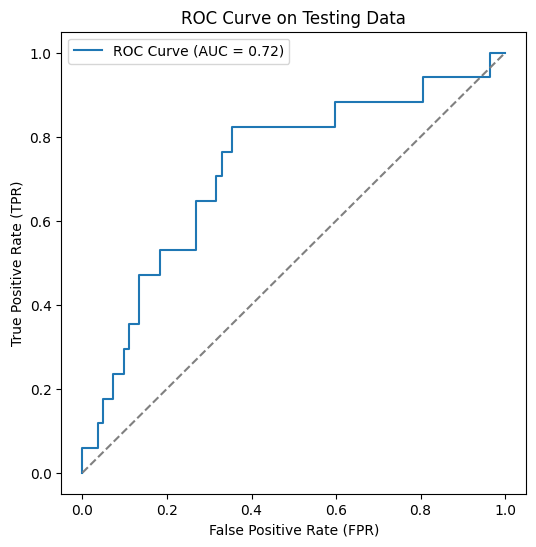

In [11]:
# Training Data Evaluation Metrics

# Predictions (discrete)
y_test_pred = best_model.predict(X_test)

print("Testing Data Evaluation Metrics:")

# Confusion matrix
cm_test = confusion_matrix(y_test, y_test_pred)
tn, fp, fn, tp = cm_test.ravel()
print(f"True Positives (TP): {tp}")
print(f"False Positives (FP): {fp}")
print(f"True Negatives (TN): {tn}")
print(f"False Negatives (FN): {fn}")

# Precision & Recall
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")

# Continuous scores for AUROC
if hasattr(best_model, "predict_proba"):
    y_scores = best_model.predict_proba(X_test)[:, 1]
elif hasattr(best_model, "decision_function"):
    y_scores = best_model.decision_function(X_test)
else:
    y_scores = y_test_pred  # fallback (not ideal)

# AUROC
roc_auc = roc_auc_score(y_test, y_scores)
print(f"AUC-ROC Score: {roc_auc:.4f}")

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_scores)
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, linestyle='-', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Random classifier line
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve on Testing Data")
plt.legend()
plt.show()

#### Data for standard SVC on normal data
Testing Data Evaluation Metrics:
True Positives (TP): 14
False Positives (FP): 35
True Negatives (TN): 47
False Negatives (FN): 3
Precision: 0.286
Recall: 0.824
AUC-ROC Score: 0.7439


In [12]:
# RETIRED MODELS (ie. better models have been found) ######################################################### 

def run_l1_ratio_logistic_regression():
    print("Running Logistic Regression with l1_ratio (Elastic Net)")

    pipeline = Pipeline([
        ('variance_threshold', VarianceThreshold(threshold=0.001)),
        ('scaler', StandardScaler()),
        ('select', SelectKBest(score_func=f_classif, k=1000)),
        ('clf', LogisticRegression(
            penalty='elasticnet',
            solver='saga',
            class_weight='balanced',
            random_state=config.SEED,
            max_iter=10000,
            verbose=1
        ))
    ])

    param_grid = {
        'clf__C': [0.01, 0.1, 1, 10],  # Smaller C = more sparsity
        'clf__l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9, 1.0],  # Mix between L1 and L2
        'select__k': [10, 20, 25, 50, 100, 500, 1000]
    }

    return pipeline, param_grid


def run_logistic_regression():
    # Define the pipeline with Logistic Regression
    # Saved under logistic_regression_model.pkl
    print("Running Logistic Regression")
    pipeline = Pipeline([
        ('variance_threshold', VarianceThreshold(threshold=0.001)), 
        ('scaler', StandardScaler()),
        ('select', SelectKBest(score_func=f_classif, k=1000)),
        ('clf', LogisticRegression(class_weight='balanced', random_state=config.SEED))
    ])

    # define hyperparameter grid for logistic regression
    param_grid = {
        'clf__C': [0.01, 0.1, 1, 10, 100],
        'select__k': [50, 100, 500, 1000]
    }
    return pipeline, param_grid

